<a href="https://colab.research.google.com/github/flybiubiu/cs231n/blob/master/Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Halfish/cs231n.git
%cd cs231n/assignment2
!pip install imageio
%cd cs231n/datasets/
!/content/cs231n/assignment2/cs231n/datasets/get_datasets.sh
%cd '/content/cs231n/assignment2'

Cloning into 'cs231n'...
remote: Enumerating objects: 191, done.
remote: Total 191 (delta 0), reused 0 (delta 0), pack-reused 191
Receiving objects: 100% (191/191), 8.21 MiB | 3.17 MiB/s, done.
Resolving deltas: 100% (66/66), done.
/content/cs231n/assignment2
/content/cs231n/assignment2/cs231n/datasets
--2019-11-25 14:03:57--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  13.4MB/s    in 14s     

2019-11-25 14:04:11 (11.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [3]:
data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


In [0]:
def dropout_forward(x, dropout_param):
  p, mode = dropout_param['p'], dropout_param['mode']
  if 'seed' in dropout_param:
    np.random.seed(dropout_param['seed'])
  mask = None
  out = None
  if mode == 'train':
    mask = np.random.rand(*x.shape) < (1 - p)
    mask = mask / (1 - p)
    out = mask * x
  elif mode == 'test':
    out = x
  cache = (dropout_param, mask)
  out = out.astype(x.dtype, copy=False)
  return out, cache

In [6]:
x = np.random.randn(500, 500) + 10
for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print 'Running tests with p = ', p
  print 'Mean of input: ', x.mean()
  print 'Mean of train-time output: ', out.mean()
  print 'Mean of test-time output: ', out_test.mean()
  print 'Fraction of train-time output set to zero: ', (out == 0).mean()
  print 'Fraction of test-time output set to zero: ', (out_test == 0).mean()
  print

Running tests with p =  0.3
Mean of input:  9.997883976266579
Mean of train-time output:  10.011334624712061
Mean of test-time output:  9.997883976266579
Fraction of train-time output set to zero:  0.29912
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  9.997883976266579
Mean of train-time output:  9.967305573694478
Mean of test-time output:  9.997883976266579
Fraction of train-time output set to zero:  0.601264
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  9.997883976266579
Mean of train-time output:  10.050206010534897
Mean of test-time output:  9.997883976266579
Fraction of train-time output set to zero:  0.748592
Fraction of test-time output set to zero:  0.0



In [0]:
def dropout_backward(dout, cache):
  dropout_param, mask = cache
  mode = dropout_param['mode']
  dx = None
  if mode == 'train':
    dx = dout * mask
  elif mode == 'test':
    dx = dout
  return dx

In [8]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print 'dx relative error: ', rel_error(dx, dx_num)

dx relative error:  1.89290534518624e-11


In [9]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print 'Running check with dropout = ', dropout
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print 'Initial loss: ', loss

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))
  print

Running check with dropout =  0
Initial loss:  3.4303317343520687
W1 relative error: 3.70e-08
W2 relative error: 5.44e-08
W3 relative error: 6.62e-07
b1 relative error: 1.02e-09
b2 relative error: 3.55e-10
b3 relative error: 3.24e-10

Running check with dropout =  0.25
Initial loss:  3.2580985481122138
W1 relative error: 4.30e-09
W2 relative error: 9.65e-09
W3 relative error: 2.32e-07
b1 relative error: 3.48e-10
b2 relative error: 9.60e-11
b3 relative error: 1.07e-09

Running check with dropout =  0.5
Initial loss:  1.8521781787686904
W1 relative error: 1.64e-09
W2 relative error: 7.47e-10
W3 relative error: 2.66e-06
b1 relative error: 1.74e-10
b2 relative error: 2.74e-10
b3 relative error: 2.12e-10



In [10]:
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print dropout

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

0
(Iteration 1 / 125) loss: inf
(Epoch 0 / 25) train acc: 0.238000; val_acc: 0.175000


cs231n/layers.py:678: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


(Epoch 1 / 25) train acc: 0.382000; val_acc: 0.237000
(Epoch 2 / 25) train acc: 0.524000; val_acc: 0.287000
(Epoch 3 / 25) train acc: 0.606000; val_acc: 0.262000
(Epoch 4 / 25) train acc: 0.670000; val_acc: 0.286000
(Epoch 5 / 25) train acc: 0.704000; val_acc: 0.266000
(Epoch 6 / 25) train acc: 0.794000; val_acc: 0.262000
(Epoch 7 / 25) train acc: 0.860000; val_acc: 0.273000
(Epoch 8 / 25) train acc: 0.874000; val_acc: 0.294000
(Epoch 9 / 25) train acc: 0.906000; val_acc: 0.275000
(Epoch 10 / 25) train acc: 0.936000; val_acc: 0.290000
(Epoch 11 / 25) train acc: 0.970000; val_acc: 0.289000
(Epoch 12 / 25) train acc: 0.950000; val_acc: 0.275000
(Epoch 13 / 25) train acc: 0.978000; val_acc: 0.288000
(Epoch 14 / 25) train acc: 0.970000; val_acc: 0.284000
(Epoch 15 / 25) train acc: 0.978000; val_acc: 0.272000
(Epoch 16 / 25) train acc: 0.980000; val_acc: 0.277000
(Epoch 17 / 25) train acc: 0.988000; val_acc: 0.283000
(Epoch 18 / 25) train acc: 0.998000; val_acc: 0.281000
(Epoch 19 / 25) tra

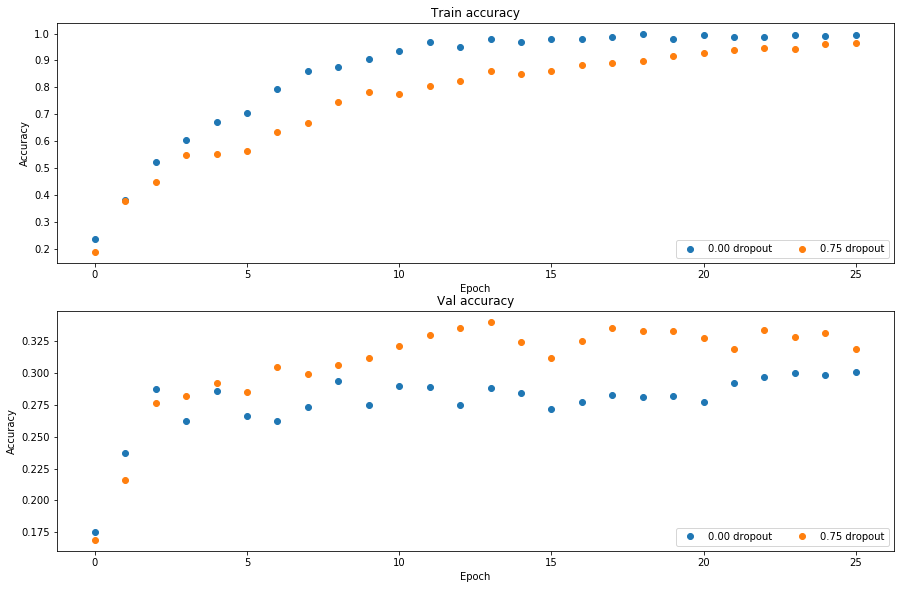

In [11]:
train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)#当前图表
plt.show()